In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import open3d as o3d
from nilearn import datasets, surface
from sklearn.model_selection import train_test_split, GridSearchCV

import torch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pyreadr
from scipy.io import loadmat
import statsmodels.api as sm

#!pip install pyreadr

In [2]:
lh_mat = loadmat('/Users/skala/Downloads/area-sm256-lh.mat')
lh_mat_df = pd.DataFrame(data=lh_mat['measmat'], index=lh_mat['dirlist'][0])
src_values = lh_mat_df.reset_index()['index'].astype('str').str.split("_").str[2].values.reshape(-1,1)
lh_mat_df['src'] = src_values.squeeze()
X = lh_mat_df

crys_orig = pyreadr.read_r("/Users/skala/Downloads/nonimaging_data_excluding_nt_5.1.rds")
cond = crys_orig[None]['nihtbx_cryst_fc'].notna()
y = crys_orig[None].loc[cond][['src_subject_id','nihtbx_cryst_fc']]
y['src'] = y['src_subject_id'].str.split('_').str[1]

In [4]:
# Find duplicate src_subject_ids
duplicate_subjects = y['src_subject_id'].value_counts()
duplicates = duplicate_subjects[duplicate_subjects > 1]

print("Duplicate src_subject_ids:")
print(duplicates)

# Show the full records for duplicated subjects
print("\nFull records for duplicated subjects:")
print(y[y['src_subject_id'].isin(duplicates.index)])

Duplicate src_subject_ids:
src_subject_id
NDAR_INVV6KTVCZH    3
NDAR_INVEYANDC02    3
NDAR_INV1MYF7VFL    3
NDAR_INV4G19G9J8    3
NDAR_INVTMVWP642    3
                   ..
NDAR_INV7N4MXK3N    2
NDAR_INV7K1MZVU9    2
NDAR_INV7G3ZUVUL    2
NDAR_INV7N4ED3TP    2
NDAR_INV7G30XLFU    2
Name: count, Length: 6804, dtype: int64

Full records for duplicated subjects:
         src_subject_id  nihtbx_cryst_fc          src
14     NDAR_INV00CY2MDM             47.0  INV00CY2MDM
16     NDAR_INV00CY2MDM             36.0  INV00CY2MDM
19     NDAR_INV00HEV6HB             57.0  INV00HEV6HB
21     NDAR_INV00HEV6HB             55.0  INV00HEV6HB
28     NDAR_INV00LH735Y             50.0  INV00LH735Y
...                 ...              ...          ...
48985  NDAR_INVH2CGXAAN             52.0  INVH2CGXAAN
49032  NDAR_INVN72UK9CX             31.0  INVN72UK9CX
49087  NDAR_INVX192FE67             55.0  INVX192FE67
49101  NDAR_INVXRR639H7             61.0  INVXRR639H7
62954  NDAR_INV1DDX454E             41.0  I

In [5]:
src_counts = y['src'].value_counts()  # Get counts of each src value
unique_src = src_counts[src_counts == 1].index  # Get src values that appear exactly once
y = y[y['src'].isin(unique_src)]

print(f"Rows before filtering: {src_counts.sum()}")
print(f"Rows after filtering: {len(y)}")
print(f"\nNumber of duplicate src values removed: {len(src_counts[src_counts > 1])}")

# Check if each index maps to exactly one src value
X.index = X.index.astype(str)
index_src_mapping = X.groupby(X.index)['src'].nunique()
all_one_to_one = (index_src_mapping == 1).all()
print(f"Each index maps to exactly one src value: {all_one_to_one}")

# Original counts for reference
print("\nCounts:")
print(f"Unique src values: {X['src'].nunique()}")
print(f"Total rows: {X['src'].shape[0]}")
print(f"Unique indices: {X.index.nunique()}")

Rows before filtering: 18994
Rows after filtering: 4802

Number of duplicate src values removed: 6804
Each index maps to exactly one src value: True

Counts:
Unique src values: 11536
Total rows: 11536
Unique indices: 11536


Check if each index maps to exactly one src value: True


<Axes: ylabel='Frequency'>

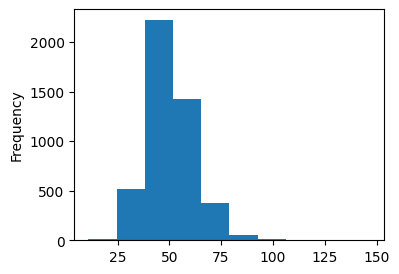

In [6]:
X.reset_index(drop=True, inplace=True)
y.drop(columns=['src_subject_id'], inplace=True)

df = X.merge(y, on='src', how='inner')
print("Check if each index maps to exactly one src value:", df.src.nunique() == df.shape[0])
df.drop(columns=['src'], inplace=True, axis=1)  #Unnecessary column
df.reset_index(inplace=True)  #Scrambled index

df['nihtbx_cryst_fc'].plot.hist(figsize=(4, 3))

In [7]:
if 'index' in df.columns:
    df.drop(columns=['index'], axis=1, inplace=True)

In [8]:
min_x = df.drop(columns=['nihtbx_cryst_fc'], axis=1).min().min()
max_x = df.drop(columns=['nihtbx_cryst_fc'], axis=1).max().max()
print(f"Min and max values of the features: {min_x:.2f}, {max_x:.2f}")

max_y = df['nihtbx_cryst_fc'].max()
min_y = df['nihtbx_cryst_fc'].min()
print(f"Max and min values of the target variable: {max_y:.2f}, {min_y:.2f}")

Min and max values of the features: 0.00, 2.57
Max and min values of the target variable: 147.00, 11.00


In [9]:
# Normalize features (X) to [0,1] range
X = df.drop(columns=['nihtbx_cryst_fc'], axis=1)
X = (X - min_x) / (max_x - min_x)  #+ 1e-8

# Normalize target (y) to [0,1] range 
y = df['nihtbx_cryst_fc']
y = (y - y.min()) / (y.max() - y.min()) #+ 1e-8

# Recombine into dataframe
df_normalized = pd.concat([X, y.rename('nihtbx_cryst_fc')], axis=1)

<Axes: ylabel='Frequency'>

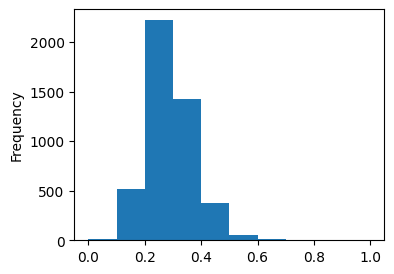

In [10]:
df_normalized['nihtbx_cryst_fc'].plot.hist(figsize=(4, 3))

In [11]:
print(df_normalized.drop(columns=['nihtbx_cryst_fc'], axis=1).min().min(), df_normalized.drop(columns=['nihtbx_cryst_fc'], axis=1).max().max())
print(y.min(), y.max())

0.0 1.0
0.0 1.0


In [12]:
df_normalized['tot'] = df_normalized.drop(columns=['nihtbx_cryst_fc'], axis=1).sum(axis=1)

In [13]:
df_normalized

,0,1,2,3,4,5,6,7,8,9,...,10234,10235,10236,10237,10238,10239,10240,10241,nihtbx_cryst_fc,tot
0,0.190878,0.172863,0.225509,0.270493,0.189438,0.221206,0.264484,0.152729,0.0,0.185606,...,0.139071,0.152432,0.168877,0.162210,0.172518,0.188103,0.209846,0.233113,0.352941,2193.568359
1,0.198612,0.215215,0.177927,0.406496,0.145116,0.232573,0.299038,0.166745,0.0,0.183179,...,0.171965,0.187931,0.206555,0.207690,0.216125,0.226095,0.245231,0.263104,0.433824,2302.734375
2,0.241936,0.179150,0.120232,0.322970,0.140113,0.220396,0.384042,0.140645,0.0,0.134591,...,0.158197,0.166168,0.174653,0.176437,0.177916,0.182700,0.189970,0.196788,0.257353,1909.751709
3,0.234218,0.250830,0.160402,0.322052,0.189079,0.218061,0.232954,0.171949,0.0,0.233533,...,0.183208,0.193011,0.203810,0.226482,0.219628,0.213970,0.222415,0.228611,0.279412,2524.635254
4,0.216354,0.234590,0.196375,0.395163,0.207244,0.207938,0.382366,0.194722,0.0,0.174630,...,0.150387,0.162863,0.176397,0.196862,0.193792,0.189405,0.200993,0.210860,0.389706,2452.859619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4610,0.184466,0.220219,0.177945,0.317941,0.162141,0.271071,0.326280,0.206056,0.0,0.169470,...,0.189160,0.211755,0.236449,0.236541,0.247404,0.260209,0.281035,0.297921,0.448529,2351.873291
4611,0.282941,0.167797,0.173695,0.391436,0.182883,0.190874,0.378009,0.214190,0.0,0.208199,...,0.209155,0.222749,0.236597,0.248430,0.248018,0.247297,0.252540,0.251983,0.316176,2506.324951
4612,0.232771,0.164949,0.156828,0.458091,0.221653,0.304250,0.373642,0.241829,0.0,0.171925,...,0.157001,0.169392,0.185061,0.169049,0.183669,0.202931,0.221954,0.241165,0.242647,2449.677002
4613,0.173168,0.216082,0.160746,0.351443,0.178338,0.190383,0.399750,0.195692,0.0,0.204357,...,0.194294,0.208721,0.223580,0.237109,0.238061,0.237327,0.249296,0.259233,0.301471,2292.811523


In [14]:
OLS_model = sm.OLS(df_normalized['nihtbx_cryst_fc'], df_normalized['tot'])
OLS_results = OLS_model.fit()
print(OLS_results.summary())

                                 OLS Regression Results                                
Dep. Variable:        nihtbx_cryst_fc   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                          5.536e+04
Date:                Mon, 24 Feb 2025   Prob (F-statistic):                        0.00
Time:                        23:42:47   Log-Likelihood:                          4903.5
No. Observations:                4615   AIC:                                     -9805.
Df Residuals:                    4614   BIC:                                     -9799.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

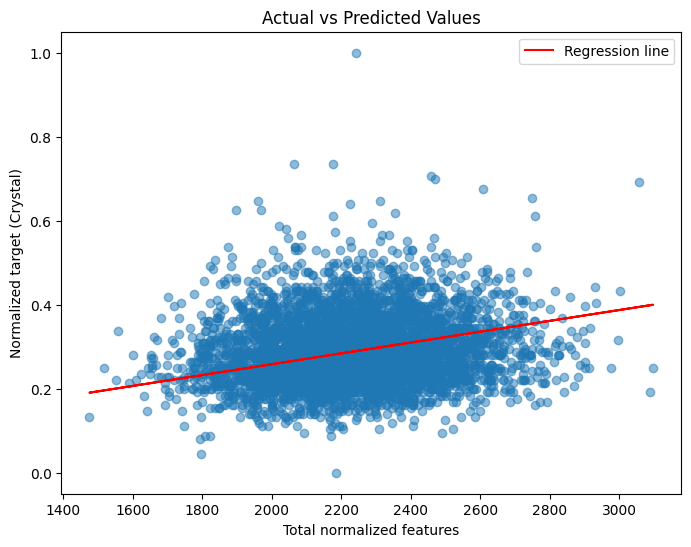

In [15]:
# Plot actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(df_normalized['tot'], df_normalized['nihtbx_cryst_fc'], alpha=0.5)
plt.plot(df_normalized['tot'], OLS_results.predict(df_normalized['tot']), color='red', label='Regression line')
plt.xlabel('Total normalized features')
plt.ylabel('Normalized target (Crystal)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [16]:
corr = df_normalized['nihtbx_cryst_fc'].corr(df_normalized['tot'])
print(f"Correlation b/w total normalized features and target: {corr:.3f}")

Correlation b/w total normalized features and target: 0.119


In [17]:
df_normalized.head(2)

,0,1,2,3,4,5,6,7,8,9,...,10234,10235,10236,10237,10238,10239,10240,10241,nihtbx_cryst_fc,tot
0,0.190878,0.172863,0.225509,0.270493,0.189438,0.221206,0.264484,0.152729,0.0,0.185606,...,0.139071,0.152432,0.168877,0.16221,0.172518,0.188103,0.209846,0.233113,0.352941,2193.568359
1,0.198612,0.215215,0.177927,0.406496,0.145116,0.232573,0.299038,0.166745,0.0,0.183179,...,0.171965,0.187931,0.206555,0.20769,0.216125,0.226095,0.245231,0.263104,0.433824,2302.734375


In [18]:
fsaverage = datasets.fetch_surf_fsaverage()

LEFT = True
pial = 'pial_left' if LEFT else 'pial_right'
coords, faces = surface.load_surf_mesh(fsaverage[pial])

X_ = df_normalized.drop(columns=['nihtbx_cryst_fc', 'tot'], axis=1)
y_ = df_normalized[['nihtbx_cryst_fc']]

# Ensure X and y have the same number of samples
if X_.shape[0] != y_.shape[0]:
	raise ValueError(f"Inconsistent number of samples: \
				  X has {X.shape[0]} samples, but y has {y.shape[0]} samples.")

In [19]:
X_.shape, y_.shape, coords.shape, faces.shape

((4615, 10242), (4615, 1), (10242, 3), (20480, 3))

In [25]:
def build_surface_adjacency(coords, faces):
    """
    Build an adjacency list (or adjacency matrix) from surface mesh faces.
    
    Args:
        coords (ndarray): (n_vertices, 3) array of vertex coordinates
        faces (ndarray): (n_faces, 3) array, each row has 3 vertex indices forming a triangular face
    
    Returns:
        adjacency_matrix (ndaray): sparse adjacency_matrix is a set of vertices adjacent to vertex v
    """
    n_vertices = coords.shape[0]
    adjacency = [set() for _ in range(n_vertices)]

    # For each face, connect its three vertices (v1, v2, v3)
    for (v1, v2, v3) in faces:
        adjacency[v1].add(v2)
        adjacency[v1].add(v3)
        adjacency[v2].add(v1)
        adjacency[v2].add(v3)
        adjacency[v3].add(v1)
        adjacency[v3].add(v2)

    n_vertices = len(adjacency)
    rows = []
    cols = []
    for v in range(n_vertices):
        for w in adjacency[v]:
            rows.append(v)
            cols.append(w)
    data = np.ones(len(rows), dtype=int)
    
    # Build a square adjacency matrix
    A = sp.csr_matrix((data, (rows, cols)), shape=(n_vertices, n_vertices))
    
    # Symmetrize (sometimes needed if faces produce directed edges—but typically it's already symmetric)
    # A = A.maximum(A.T)
    
    return A

A_csr = build_surface_adjacency(coords, faces)
edge_index = torch.tensor(np.array(A_csr.nonzero()), dtype=torch.long)

# Convert CSR matrix to COO format first
A_coo = A_csr.tocoo()

# Create indices and values tensors
indices = torch.LongTensor(np.vstack((A_coo.row, A_coo.col)))
values = torch.FloatTensor(A_coo.data)
shape = torch.Size(A_csr.shape)

# Create sparse torch tensor in COO format
A_torch = torch.sparse_coo_tensor(indices, values, shape)

'\n# Convert CSR matrix to COO format first\nA_coo = A_csr.tocoo()\n\n# Create indices and values tensors\nindices = torch.LongTensor(np.vstack((A_coo.row, A_coo.col)))\nvalues = torch.FloatTensor(A_coo.data)\nshape = torch.Size(A_csr.shape)\n\n# Create sparse torch tensor in COO format\nA_torch = torch.sparse_coo_tensor(indices, values, shape)\n'

In [26]:
edge_index.shape

torch.Size([2, 61440])

In [30]:
type(edge_index), type(A_torch)

(torch.Tensor, torch.Tensor)

In [34]:
edge_index.numpy()

array([[    0,     0,     0, ..., 10241, 10241, 10241],
       [ 2562,  2564,  2565, ...,  9918, 10161, 10240]], shape=(2, 61440))

In [35]:
def visualize_brain_graph(coords, edge_index):
    # Create visualization window
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="Brain Graph Structure", width=800, height=800)
    
    # Set rendering options
    render_option = vis.get_render_option()
    render_option.background_color = [0, 0, 0]  # Black background
    render_option.point_size = 2.0
    
    # Create point cloud for nodes
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(coords)
    
    # Set default color for nodes (e.g., white)
    colors = np.ones((len(coords), 3)) * 0.8  # Light gray color
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Create line set for edges
    edge_indices = edge_index.numpy().T  # Convert to numpy and transpose
    lines = o3d.geometry.LineSet()
    lines.points = o3d.utility.Vector3dVector(coords)
    lines.lines = o3d.utility.Vector2iVector(edge_indices)
    
    # Set edge colors (e.g., blue)
    edge_colors = np.zeros((len(edge_indices), 3))
    edge_colors[:, 2] = 1.0  # Blue color for edges
    lines.colors = o3d.utility.Vector3dVector(edge_colors)
    
    # Add geometries to visualizer
    vis.add_geometry(pcd)
    vis.add_geometry(lines)
    
    # Set camera view
    vis.get_view_control().set_zoom(0.8)
    
    # Run visualization
    vis.run()
    vis.destroy_window()

In [37]:
visualize_brain_graph(coords, edge_index)

2025-02-25 00:00:13.274 python[22587:801391] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-25 00:00:13.274 python[22587:801391] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [39]:
edge_index.numpy().T

array([[    0,  2562],
       [    0,  2564],
       [    0,  2565],
       ...,
       [10241,  9918],
       [10241, 10161],
       [10241, 10240]], shape=(61440, 2))

In [40]:
A_torch

tensor(indices=tensor([[    0,     0,     0,  ..., 10241, 10241, 10241],
                       [ 2562,  2564,  2565,  ...,  9918, 10161, 10240]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(10242, 10242), nnz=61440, layout=torch.sparse_coo)

In [48]:
def create_graph_data(X, y, edge_index):
    graphs = []
    for i in range(X.shape[0]):
        # Node features for this subject
        x = torch.FloatTensor(X[i].reshape(-1, 1))
        # Create graph object
        data = Data(
            x=x,
            edge_index=edge_index,
            y=torch.FloatTensor(y[i])
        )
        graphs.append(data)
    return graphs

graph_list = create_graph_data(X_.values, y_.values, edge_index)

In [60]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 8)
        self.linear = torch.nn.Linear(8, 1)

    def forward(self, x, edge_index):
        # First Graph Convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # Second Graph Convolution
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Global mean pooling
        x = global_mean_pool(x, torch.zeros(x.shape[0], dtype=torch.long))
        
        # Linear layer for final prediction
        x = self.linear(x)
        
        return x

# Initialize model
model = GCN(num_node_features=1)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Split data into train and test sets
#train_size = int(0.8 * len(graph_list))
#test_size = len(graph_list) - train_size
train_dataset, test_dataset = train_test_split(graph_list, test_size=0.2, random_state=42)



# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
for epoch in range(100):
    # Training
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Testing
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            total_test_loss += loss.item()
    
    
    avg_train_loss = total_train_loss/len(train_loader)
    avg_test_loss = total_test_loss/len(test_loader)
    print(f'Epoch {epoch+1:03d}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch 001, Train Loss: 0.0201, Test Loss: 0.0066
Epoch 002, Train Loss: 0.0069, Test Loss: 0.0065
Epoch 003, Train Loss: 0.0068, Test Loss: 0.0069
Epoch 004, Train Loss: 0.0069, Test Loss: 0.0066
Epoch 005, Train Loss: 0.0069, Test Loss: 0.0067
Epoch 006, Train Loss: 0.0070, Test Loss: 0.0065
Epoch 007, Train Loss: 0.0070, Test Loss: 0.0066
Epoch 008, Train Loss: 0.0071, Test Loss: 0.0065
Epoch 009, Train Loss: 0.0068, Test Loss: 0.0067
Epoch 010, Train Loss: 0.0071, Test Loss: 0.0065
Epoch 011, Train Loss: 0.0071, Test Loss: 0.0065
Epoch 012, Train Loss: 0.0069, Test Loss: 0.0066
Epoch 013, Train Loss: 0.0070, Test Loss: 0.0078
Epoch 014, Train Loss: 0.0070, Test Loss: 0.0067
Epoch 015, Train Loss: 0.0069, Test Loss: 0.0065
Epoch 016, Train Loss: 0.0071, Test Loss: 0.0070
Epoch 017, Train Loss: 0.0070, Test Loss: 0.0067
Epoch 018, Train Loss: 0.0069, Test Loss: 0.0071
Epoch 019, Train Loss: 0.0069, Test Loss: 0.0066
Epoch 020, Train Loss: 0.0070, Test Loss: 0.0075
Epoch 021, Train Los

KeyboardInterrupt: 